In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

## 1. Load data

In [2]:
imgStack = np.load('Data/3D_CW_data/17-08-24-L2-CL-VNC-Raw.npy')
Y = imgStack.copy()
Y = Y.transpose([2, 3, 1, 0]) # x, y, z, T
dx, dy, dz, dt = Y.shape

## 2. Detrend raw signal on pixels

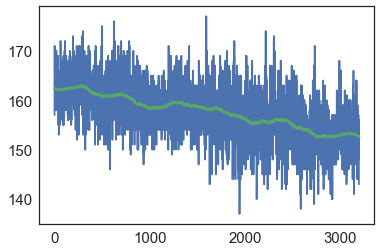

In [3]:
# from scipy import signal
# Ysg = signal.savgol_filter(Y, 511, 3, axis=-1)
# np.save('tmpData/Y_sg_CW_VNC', Ysg)
Ysg = np.load('tmpData/Y_sg_CW_VNC.npy')
Y_detr = Y - Ysg
# compare raw pixel and trend
plt.plot(Y[0, 0, 0, :])
plt.plot(Ysg[0, 0, 0, :], linewidth=3)
plt.show()

## 3.Spatial denoising using patched SVD (Greedy algorithm)

### 3.1 Denoising for independent images per stack along z

In [ ]:
from denoiseLocalPCA.denoise import temporal as svd_patch
nblocks=[5, 5]
dx=4
maxlag=5
confidence=0.99
greedy=False,
fudge_factor=1
mean_th_factor=1.15
U_update=False
min_rank=1
stim_knots=None
stim_delta=0

Y_svd = Y_detr.copy()
for nDepth in range(Y_detr.shape[2]):
    img = np.squeeze(Y_detr[:, :, nDepth, :])
    Y_svd[:, :, nDepth, :], _ = svd_patch(img, nblocks=nblocks, dx=dx, stim_knots=stim_knots, stim_delta=stim_delta)

# np.save('Y_svd_CW_VNC', Y_svd)

In [4]:
Y_svd = np.load('tmpData/Y_svd_CW_VNC.npy')
Y_svd_sg = Y_svd + Ysg

#### Performance for selected image

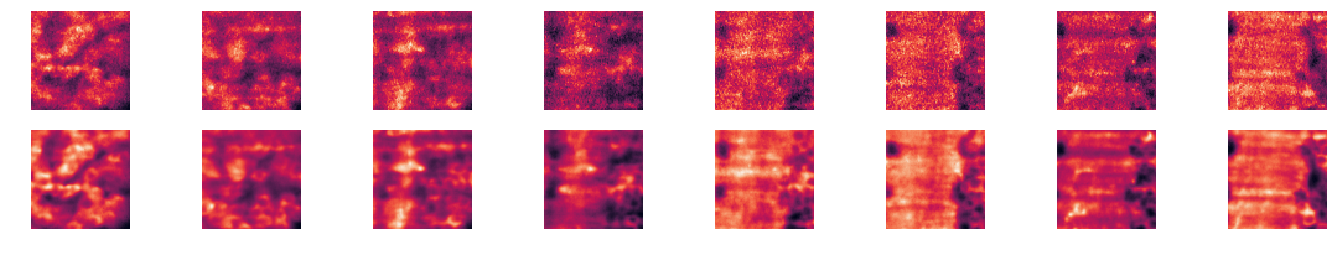

In [5]:
numCol = 8
step = dz//numCol
fig, ax = plt.subplots(2, numCol, figsize=(24, 4))
for nplot in range(numCol):
    ax[0, nplot].imshow(Y[:, :, step*nplot, 810])
    ax[0, nplot].axis('off')
    ax[1, nplot].imshow(Y_svd_sg[:, :, step*nplot, 810])
    ax[1, nplot].axis('off')
plt.show()

#### Performance on single pixels

In [6]:
percentage_noise = ((Y_detr - Y_svd)**2).mean(axis=-1)/Y_detr.var(axis=-1)
print('Average percentage noise removed %f'%(percentage_noise[:].mean()))

Average percentage noise removed 0.810940


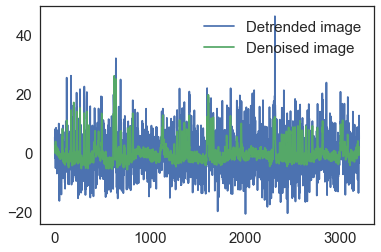

In [7]:
plt.plot(Y_detr[70, 40, 20, :], label='Detrended image')
plt.plot(Y_svd[70, 40, 20, :], label='Denoised image')
plt.legend()
plt.show()

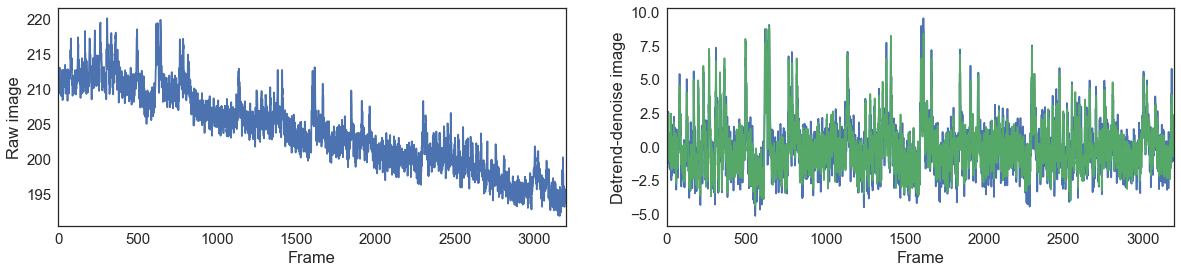

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(Y[0:10, 70:79, step*6, :].mean(axis=0).mean(axis=0))
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Raw image')
ax[0].set_xlim([0, dt])

ax[1].plot(Y_detr[0:10, 70:79, step*6, :].mean(axis=0).mean(axis=0))
ax[1].plot(Y_svd[0:10, 70:79, step*6, :].mean(axis=0).mean(axis=0))
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Detrend-denoise image')
ax[1].set_xlim([0, dt])
plt.show()

### 3.2 Denoising for consecutive stacks

In [9]:
from denoiseLocalPCA.cdenoise import *

In [10]:
Y_detr_ave = Y_detr.mean(axis=-1) # remove mean
Y_detr_std = Y_detr.std(axis=-1) # normalization
Y_detr_ = Y_detr.transpose([2, 0, 1, 3])
Y_detr_ = (Y_detr_ - Y_detr_.mean(axis=-1)[:,:,:,np.newaxis])/Y_detr_.std(axis=-1)[:,:,:,np.newaxis]

In [11]:
# remove top few (6) components in each z of stack
rank_k = 6
Y_low_rank = [low_rank_svd(slice_, rank_k) for slice_ in Y_detr_]
Y_detr_ = Y_detr_ - Y_low_rank

In [12]:
dx, dy, dz, dt = Y.shape
nx = 5 # number of blocks along x
ny = 5
zstack_step = 4
nz = np.ceil(dz/zstack_step).astype('int')
ox = 2 # number of pixels overlapped between two blocks along x axis
oy = 2
oz = 1
arrs = split_to_blocks((dx, dy, dz), (nx, ny, nz), (ox, oy, oz))
arrs = [arrs[2], arrs[0], arrs[1]]
blocks = get_blocks_from_index_arr(Y_detr_, arrs)

In [15]:
maxlag=5
confidence=0.99
greedy=False
fudge_factor=1
mean_th_factor=1.15
U_update=False
min_rank=1
stim_knots=None
stim_delta=0
interleave=False

block_Y_cubic_svd, block_rank = run_single(blocks, maxlag=maxlag, confidence=confidence, greedy=greedy, 
                                fudge_factor=fudge_factor, mean_th_factor=mean_th_factor, U_update=U_update, 
                                min_rank=min_rank, stim_knots=stim_knots, stim_delta=stim_delta)


Running 150 blocks in 14 cpus
	M	rank: 1	run_time: 43.847718
	M	rank: 5	run_time: 50.090122
	M	rank: 8	run_time: 51.416978
	M	rank: 5	run_time: 53.639537
	M	rank: 4	run_time: 55.015855
	M	rank: 9	run_time: 55.763580
	M	rank: 8	run_time: 61.625518
	M	rank: 9	run_time: 65.343157
	M	rank: 3	run_time: 61.456212
	M	rank: 3	run_time: 70.343062
	M	rank: 2	run_time: 51.565116
	M	rank: 4	run_time: 49.151743
	M	rank: 1	run_time: 82.685654
	M	rank: 5	run_time: 72.842870
	M	rank: 4	run_time: 76.107159
	M	rank: 4	run_time: 49.769455
	M	rank: 3	run_time: 86.351266
	M	rank: 5	run_time: 56.629637
	M	rank: 10	run_time: 57.797323
	M	rank: 6	run_time: 53.494389
	M	rank: 7	run_time: 53.044281
	M	rank: 2	run_time: 60.997267
	M	rank: 2	run_time: 67.223205
	M	rank: 4	run_time: 56.556186
	M	rank: 7	run_time: 60.498819
	M	rank: 2	run_time: 58.607085
	M	rank: 12	run_time: 44.560751
	M	rank: 5	run_time: 62.895020
	M	rank: 8	run_time: 44.347052
	M	rank: 11	run_time: 60.755865
	M	rank: 7	run_time: 54.735580
	M	ran

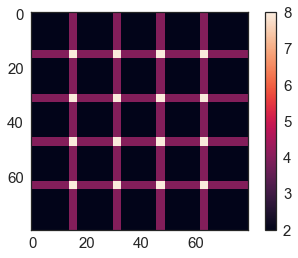

In [16]:
block_mat, block_cout = combine_blocks(block_Y_cubic_svd, Y_detr_.shape, blocks)
plt.imshow(block_cout[3, :, :, 0])
plt.colorbar()
plt.show()

In [17]:
Y_cubic_svd = block_mat/block_cout
Y_cubic_svd = Y_cubic_svd + Y_low_rank
Y_cubic_svd = Y_cubic_svd.transpose([1, 2, 0, 3])
Y_cubic_svd = (Y_cubic_svd + Y_detr_ave[:,:,:,np.newaxis])*Y_detr_std[:,:,:,np.newaxis]

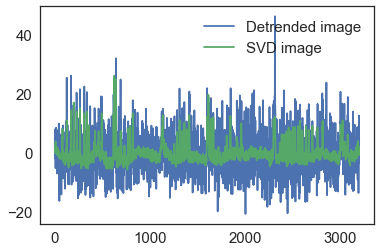

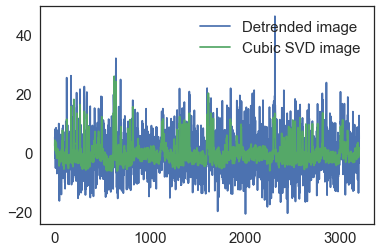

In [18]:
plt.plot(Y_detr[70, 40, 20, :], label='Detrended image')
plt.plot(Y_svd[70, 40, 20, :], label='SVD image')
plt.legend()
plt.show()
plt.plot(Y_detr[70, 40, 20, :], label='Detrended image')
plt.plot(Y_cubic_svd[70, 40, 20, :], label='Cubic SVD image')
plt.legend()
plt.show()

In [19]:
percentage_noise = ((Y_detr - Y_svd)**2).mean(axis=-1)/Y_detr.var(axis=-1)
percentage_c_noise = ((Y_detr - Y_cubic_svd)**2).mean(axis=-1)/Y_detr.var(axis=-1)
print('Average percentage noise removed %f'%(percentage_noise[:].mean()))
print('Average percentage noise removed %f'%(percentage_c_noise[:].mean()))

Average percentage noise removed 0.810940
Average percentage noise removed 0.810784


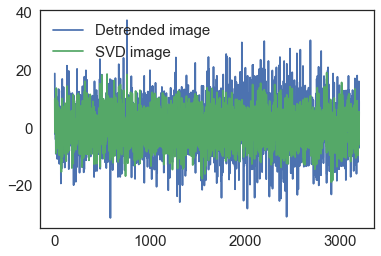

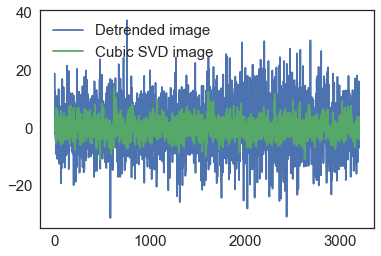

In [20]:
diff = percentage_c_noise - percentage_noise
ind = np.where(diff==diff.max())
plt.plot(Y_detr[ind[0][0], ind[1][0], ind[2][0], :], label='Detrended image')
plt.plot(Y_svd[ind[0][0], ind[1][0], ind[2][0], :], label='SVD image')
plt.legend()
plt.show()
plt.plot(Y_detr[ind[0][0], ind[1][0], ind[2][0], :], label='Detrended image')
plt.plot(Y_cubic_svd[ind[0][0], ind[1][0], ind[2][0], :], label='Cubic SVD image')
plt.legend()
plt.show()